In [30]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from PIL import Image
import scipy.stats as st
import pymc as pm
import arviz as az
import scipy.linalg as la
import seaborn as sns
import sqlite3
az.style.use('arviz-darkgrid')

In [10]:
bball = pd.read_csv('Use_This.csv')
bball

,Unnamed: 0,game_id,player_id,starter,mp,did_not_play,is_inactive,fantasy_points,player_name,position,team,opponent,teamscore,opponentscore,date,avg_pts
0,5038,202101200TOR,achiupr01,0,14:24,0,0,12.8,Precious Achiuwa,F,TOR,MIA,102,111,120,12.800000
1,5560,202101220TOR,achiupr01,0,11:32,0,0,10.7,Precious Achiuwa,F,TOR,MIA,101,81,122,12.800000
2,14277,202102240MIA,achiupr01,0,6:00,0,0,3.4,Precious Achiuwa,F,TOR,MIA,108,116,224,11.750000
3,42496,202110200TOR,achiupr01,1,18:30,0,0,18.4,Precious Achiuwa,F,TOR,WAS,83,98,1020,8.966667
4,42647,202110220BOS,achiupr01,1,24:50,0,0,35.0,Precious Achiuwa,F,TOR,BOS,115,83,1022,11.325000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30829,53979,202112200LAC,zubaciv01,1,27:21,0,0,31.9,Ivica Zubac,C,LAC,SAS,92,116,1220,20.970000
30830,54290,202112220SAC,zubaciv01,1,26:39,0,0,22.2,Ivica Zubac,C,LAC,SAC,105,89,1222,23.180000
30831,54770,202112260LAC,zubaciv01,1,27:22,0,0,36.2,Ivica Zubac,C,LAC,DEN,100,103,1226,22.760000
30832,54968,202112270LAC,zubaciv01,1,21:45,0,0,19.3,Ivica Zubac,C,LAC,BRK,108,124,1227,24.130000


In [15]:
bball.team.unique()

array(['TOR', 'MEM', 'MIA', 'BRK', 'NOP', 'MIL', 'CLE', 'SAS', 'LAL',
       'ORL', 'CHI', 'HOU', 'WAS', 'PHO', 'UTA', 'NYK', 'CHO', 'SAC',
       'DEN', 'PHI', 'LAC', 'OKC', 'MIN', 'GSW', 'DET', 'IND', 'POR',
       'ATL', 'BOS', 'DAL'], dtype=object)

## Creating new variables

In [17]:
# Team rank for 20-2021 season - two teams for each val (bc seperated by E & W conferences)

# Fx to map the values
def set_ranks(row_number, assigned_value):
    return assigned_value[row_number]
 
# Create the dictionary
ranks ={'PHI':1,
        'BRK':2,
        'MIL':3,
        'NYK':4,
        'ATL':5,
        'MIA':6,
        'BOS':7,
        'WAS':8,
        'IND':9,
        'CHO':10,
        'CHI':11,
        'TOR':12, 
        'CLE':13,
        'ORL':14,
        'DET':15,
        
        'UTA':1,
        'PHO':2,
        'DEN':3,
        'LAC':4,
        'DAL':5,
        'POR':6,
        'LAL':7,
        'MEM':8, 
        'GSW':9,
        'SAS':10,
        'NOP':11, 
        'SAC':12,
        'MIN':13,
        'OKC':14,
        'HOU':15
        }
 
# Add a new col
bball['team_rank'] = bball['team'].apply(set_ranks, args =(ranks, ))

In [25]:
# Conference
# 0 for East, 1 for West

bball['conference'] = [0 if x =='PHI' or x =='BRK' or x =='MIL' or x =='NYK' or x =='ATL' or x =='MIA' or x =='BOS' or x =='WAS' or x =='IND' or x =='CHO' or x =='CHI' or x =='TOR' or x =='CLE' or x =='ORL' or x =='DET' else 1 for x in bball['team']]

In [60]:
# Change var name for easier join

bball = bball.rename(columns={'player_name':'NAME'})

In [89]:
# Import box stats data (source: https://www.nbastuffer.com/2020-2021-nba-player-stats/) (20-21 season)

box_stats = pd.read_excel('21reg_season.xlsx', header=1).reset_index()

In [91]:
box_stats = box_stats.drop(columns='RANK')

In [92]:
pd.set_option('display.max_columns', 500)
box_stats.columns

Index(['index', 'FULL NAME', 'TEAM', 'POS', 'AGE', 'GP', 'MPG',
       'MIN%Minutes PercentagePercentage of team minutes used by a player while he was on the floor',
       'USG%Usage RateUsage rate, a.k.a., usage percentage is an estimate of the percentage of team plays used by a player while he was on the floor',
       'TO%Turnover RateA metric that estimates the number of turnovers a player commits per 100 possessions',
       'FTA', 'FT%', '2PA', '2P%', '3PA', '3P%',
       'eFG%Effective Shooting PercentageWith eFG%, three-point shots made are worth 50% more than two-point shots made. eFG% Formula=(FGM+ (0.5 x 3PM))/FGA',
       'TS%True Shooting PercentageTrue shooting percentage is a measure of shooting efficiency that takes into account field goals, 3-point field goals, and free throws.',
       'PPGPointsPoints per game.', 'RPGReboundsRebounds per game.',
       'TRB%Total Rebound PercentageTotal rebound percentage is estimated percentage of available rebounds grabbed by the 

In [93]:
box_stats = box_stats.rename(columns={'FULL NAME':'NAME',
                                      'index':'RANK', 
                                      'MIN%Minutes PercentagePercentage of team minutes used by a player while he was on the floor':'MIN%',
                                      'USG%Usage RateUsage rate, a.k.a., usage percentage is an estimate of the percentage of team plays used by a player while he was on the floor':'USG%',
                                       'TO%Turnover RateA metric that estimates the number of turnovers a player commits per 100 possessions':'TO%',
                                       'eFG%Effective Shooting PercentageWith eFG%, three-point shots made are worth 50% more than two-point shots made. eFG% Formula=(FGM+ (0.5 x 3PM))/FGA':'eFG%',
                                       'TS%True Shooting PercentageTrue shooting percentage is a measure of shooting efficiency that takes into account field goals, 3-point field goals, and free throws.':'TS%',
                                       'PPGPointsPoints per game.':'PPG', 
                                       'RPGReboundsRebounds per game.':'RPG',
                                       'TRB%Total Rebound PercentageTotal rebound percentage is estimated percentage of available rebounds grabbed by the player while the player is on the court.':'TRB%',
                                       'APGAssistsAssists per game.':'APG',
                                       'AST%Assist PercentageAssist percentage is an estimated percentage of teammate field goals a player assisted while the player is on the court':'AST%',
                                       'SPGStealsSteals per game.':'SPG', 
                                       'BPGBlocksBlocks per game.':'BPG',
                                       'TOPGTurnoversTurnovers per game.':'TOPG',
                                       'VIVersatility IndexVersatility index is a metric that measures a player’s ability to produce in points, assists, and rebounds. The average player will score around a five on the index, while top players score above 10':'VI',
                                       'ORTGOffensive RatingIndividual offensive rating is the number of points produced by a player per 100 total individual possessions.':'ORTG',
                                       'DRTGDefensive RatingIndividual defensive rating estimates how many points the player allowed per 100 possessions he individually faced while staying on the court.':'DRTG'})

#### Box Stats Variable Descriptions:  

    - RANK: player rank
    - MIN%: Minutes PercentagePercentage of team minutes used by a player while he was on the floor
    - USG%: Usage RateUsage rate, a.k.a., usage percentage is an estimate of the percentage of team plays used by a player while he was on the floor
    - TO%: Turnover RateA metric that estimates the number of turnovers a player commits per 100 possession
    - eFG%: Effective Shooting PercentageWith eFG%, three-point shots made are worth 50% more than two-point shots made. eFG% Formula=(FGM+ (0.5 x 3PM))/FGA
    - TS%: True Shooting PercentageTrue shooting percentage is a measure of shooting efficiency that takes into account field goals, 3-point field goals, and free throws
    - PPG: PointsPoints per game
    - RPG: ReboundsRebounds per game
    - TRB%: Total Rebound PercentageTotal rebound percentage is estimated percentage of available rebounds grabbed by the player while the player is on the court
    - APG: AssistsAssists per game
    - AST%: Assist PercentageAssist percentage is an estimated percentage of teammate field goals a player assisted while the player is on the court
    - SPG: StealsSteals per game
    - BPG: BlocksBlocks per game
    - TOPG: TurnoversTurnovers per game
    - VI: Versatility Index = Versatility index is a metric that measures a player’s ability to produce in points, assists, and rebounds. The average player will score around a five on the index, while top players score above 10
    - ORTG: Offensive RatingIndividual offensive rating is the number of points produced by a player per 100 total individual possessions
    - DRTG: Defensive RatingIndividual defensive rating estimates how many points the player allowed per 100 possessions he individually faced while staying on the court

In [95]:
# Make teams all caps for an easier join

box_stats['TEAM'] = box_stats['TEAM'].str.upper()

In [96]:
box_stats

,RANK,NAME,TEAM,POS,AGE,GP,MPG,MIN%,USG%,TO%,FTA,FT%,2PA,2P%,3PA,3P%,eFG%,TS%,PPG,RPG,TRB%,APG,AST%,SPG,BPG,TOPG,VI,ORTG,DRTG
0,0,Precious Achiuwa,MIA,F,21.66,61,12.1,25.2,19.5,13.5,110,0.509,227,0.546,1,0.000,0.544,0.550,5.0,3.4,16.1,0.5,6.1,0.33,0.46,0.70,6.7,106.8,99.7
1,1,Jaylen Adams,MIL,G,25.03,7,2.6,5.4,18.5,0.0,0,0.000,6,0.167,2,0.000,0.125,0.125,0.3,0.4,8.7,0.3,12.6,0.00,0.00,0.00,5.1,NaN,NaN
2,2,Steven Adams,NOR,C,27.83,58,27.7,57.6,11.7,17.7,135,0.444,305,0.620,3,0.000,0.614,0.596,7.6,8.9,17.4,1.9,9.1,0.93,0.66,1.36,7.3,119.7,107.8
3,3,Bam Adebayo,MIA,C-F,23.83,64,33.5,69.7,23.7,15.0,354,0.799,792,0.573,8,0.250,0.571,0.626,18.7,9.0,15.3,5.4,26.9,1.17,1.03,2.64,11.6,121.7,105.0
4,4,LaMarcus Aldridge,SAN,C-F,35.83,21,25.9,54.0,22.7,7.0,37,0.838,173,0.509,75,0.360,0.518,0.545,13.7,4.5,9.2,1.7,10.2,0.38,0.86,0.95,7.3,107.3,110.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
621,621,Delon Wright,SAC,G,29.06,27,25.8,53.7,17.1,12.7,36,0.833,142,0.500,83,0.398,0.536,0.563,10.0,3.9,8.4,3.6,18.9,1.56,0.37,1.30,8.1,114.9,115.4
622,622,Thaddeus Young,CHI,F,32.90,68,24.3,50.6,22.3,16.0,113,0.628,618,0.579,45,0.267,0.567,0.577,12.1,6.2,14.1,4.3,27.1,1.09,0.59,2.00,11.3,115.3,104.5
623,623,Trae Young,ATL,G,22.66,63,33.7,70.3,33.0,16.2,546,0.886,715,0.491,397,0.343,0.499,0.589,25.3,3.9,6.3,9.4,45.5,0.84,0.17,4.14,11.6,116.9,111.9
624,624,Cody Zeller,CHA,F-C,28.61,48,20.9,43.6,18.3,11.9,119,0.714,296,0.598,28,0.143,0.565,0.599,9.4,6.8,17.7,1.8,13.2,0.56,0.35,1.06,9.3,121.8,101.5


#### NEW DATAFRAME!

In [97]:
# Join the two dataframes on the player name

stats = box_stats.merge(bball, on='NAME', how='inner')

In [98]:
stats = stats.drop(columns=['Unnamed: 0', 'team'])

In [113]:
# Convert time to something we can work with
stats['mp'] = stats['mp'].str.replace(':', '.')

In [115]:
stats['mp'] = pd. to_numeric(stats['mp']) 

In [116]:
stats

,RANK,NAME,TEAM,AGE,GP,MPG,MIN%,USG%,TO%,FTA,FT%,2PA,2P%,3PA,3P%,eFG%,TS%,PPG,RPG,TRB%,APG,AST%,SPG,BPG,TOPG,VI,ORTG,DRTG,game_id,player_id,starter,mp,did_not_play,is_inactive,fantasy_points,POSITION,opponent,teamscore,opponentscore,date,avg_pts,team_rank,conference
0,0,Precious Achiuwa,MIA,21.66,61,12.1,25.2,19.5,13.5,110,0.509,227,0.546,1,0.00,0.544,0.550,5.0,3.4,16.1,0.5,6.1,0.33,0.46,0.70,6.7,106.8,99.7,202101200TOR,achiupr01,0,14.24,0,0,12.8,F,MIA,102,111,120,12.800000,12,0
1,0,Precious Achiuwa,MIA,21.66,61,12.1,25.2,19.5,13.5,110,0.509,227,0.546,1,0.00,0.544,0.550,5.0,3.4,16.1,0.5,6.1,0.33,0.46,0.70,6.7,106.8,99.7,202101220TOR,achiupr01,0,11.32,0,0,10.7,F,MIA,101,81,122,12.800000,12,0
2,0,Precious Achiuwa,MIA,21.66,61,12.1,25.2,19.5,13.5,110,0.509,227,0.546,1,0.00,0.544,0.550,5.0,3.4,16.1,0.5,6.1,0.33,0.46,0.70,6.7,106.8,99.7,202102240MIA,achiupr01,0,6.00,0,0,3.4,F,MIA,108,116,224,11.750000,12,0
3,0,Precious Achiuwa,MIA,21.66,61,12.1,25.2,19.5,13.5,110,0.509,227,0.546,1,0.00,0.544,0.550,5.0,3.4,16.1,0.5,6.1,0.33,0.46,0.70,6.7,106.8,99.7,202110200TOR,achiupr01,1,18.30,0,0,18.4,F,WAS,83,98,1020,8.966667,12,0
4,0,Precious Achiuwa,MIA,21.66,61,12.1,25.2,19.5,13.5,110,0.509,227,0.546,1,0.00,0.544,0.550,5.0,3.4,16.1,0.5,6.1,0.33,0.46,0.70,6.7,106.8,99.7,202110220BOS,achiupr01,1,24.50,0,0,35.0,F,BOS,115,83,1022,11.325000,12,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32244,625,Ivica Zubac,LAC,24.16,72,22.3,46.5,15.2,14.7,171,0.789,390,0.656,4,0.25,0.654,0.693,9.0,7.2,18.1,1.3,7.9,0.33,0.86,1.13,7.9,134.5,101.0,202112200LAC,zubaciv01,1,27.21,0,0,31.9,C,SAS,92,116,1220,20.970000,4,1
32245,625,Ivica Zubac,LAC,24.16,72,22.3,46.5,15.2,14.7,171,0.789,390,0.656,4,0.25,0.654,0.693,9.0,7.2,18.1,1.3,7.9,0.33,0.86,1.13,7.9,134.5,101.0,202112220SAC,zubaciv01,1,26.39,0,0,22.2,C,SAC,105,89,1222,23.180000,4,1
32246,625,Ivica Zubac,LAC,24.16,72,22.3,46.5,15.2,14.7,171,0.789,390,0.656,4,0.25,0.654,0.693,9.0,7.2,18.1,1.3,7.9,0.33,0.86,1.13,7.9,134.5,101.0,202112260LAC,zubaciv01,1,27.22,0,0,36.2,C,DEN,100,103,1226,22.760000,4,1
32247,625,Ivica Zubac,LAC,24.16,72,22.3,46.5,15.2,14.7,171,0.789,390,0.656,4,0.25,0.654,0.693,9.0,7.2,18.1,1.3,7.9,0.33,0.86,1.13,7.9,134.5,101.0,202112270LAC,zubaciv01,1,21.45,0,0,19.3,C,BRK,108,124,1227,24.130000,4,1


In [103]:
print('POS:','\n', sum(stats.POS.value_counts()), '\n', stats.POS.value_counts())
print('\n')
print('position: ','\n', sum(stats.position.value_counts()), '\n', stats.position.value_counts())

POS: 
 32249 
 G      12141
F       8361
G-F     3298
C       2691
F-C     2579
F-G     1749
C-F     1430
Name: POS, dtype: int64


position:  
 32249 
 SG    7896
PG    6293
SF    6206
C     5615
PF    5526
G      359
F      354
Name: position, dtype: int64


In [107]:
# We only want one position column

stats = stats.drop(columns='POS')

In [109]:
stats = stats.rename(columns={'position':'POSITION'})

In [104]:
# How many player choices do we have?

stats.NAME.value_counts()

Damian Jones       177
Jarrett Allen      162
James Harden       154
Lou Williams       146
Blake Griffin      146
                  ... 
Sekou Doumbouya      3
Dwayne Bacon         3
Daniel Oturu         1
Dante Exum           1
Grant Riller         1
Name: NAME, Length: 442, dtype: int64

In [112]:
# Write to csv
#stats.to_csv('player_game_stats.csv')

## Begin Modeling

In [147]:
# Numeric preds
numeric_predictors = [['AGE', 'GP', 'MPG', 'MIN%', 'USG%', 'TO%', 'FTA', 'FT%', '2PA', '2P%', '3PA', '3P%', 'eFG%', 'TS%', 'PPG', 'RPG', 'TRB%', 'APG', 'AST%', 'SPG', 'BPG', 'TOPG', 'VI', 'ORTG', 'DRTG', 'starter', 'mp', 'did_not_play', 'is_inactive', 'fantasy_points', 'teamscore', 'opponentscore', 'avg_pts', 'team_rank', 'conference']]

# Number of player-game observations
n = stats.shape[0]

# Grouped variable
position = stats['POSITION']

positions = stats['POSITION'].unique()
npositions = len(positions)

# Predictor variables
min_percent = stats['MIN%']
mp = stats['mp'] #minutes played in a certain game
avg_f_pts = stats['avg_pts']
team_rank = stats['team_rank']
ppg = stats['PPG']
efg = stats['eFG%'] #effective shooting percentage
vi = stats['VI'] #versitality index
ortg = stats['ORTG'] #offensive rating
ft = stats['FT%']
age = stats['AGE']

opp = stats['opponent']

# Lookup table for each position
pos_lookup = dict(zip(positions, range(npositions)))

def set_ranks(row_number, assigned_value):
    return assigned_value[row_number]
ids ={'F': 0, 'C': 1, 'SG': 2, 'PF': 3, 'SF': 4, 'PG': 5, 'G': 6}
stats['position_id'] = stats['POSITION'].apply(set_ranks, args =(ids, ))
position = stats['position_id'] #position holds the numeric identifiers for the positions

##### Model: Fantasy points as response

*struggling to get this right 

In [158]:
with pm.Model() as hierarchical_numeric_model:

    # Priors for the model parameters
    # Gaussians for the means of the priors of the random intercepts and slopes
    mu_a = pm.Normal('mu_a', mu=0., sigma=1e5)
    mu_b = pm.Normal('mu_b', mu=0., sigma=1e5)
    
    # Half-Cauchy for the standard deviations of the priors 
    # of the random intercepts and slopes
    sigma_a =  pm.HalfCauchy('sigma_a', 1e5)
    sigma_b =  pm.HalfCauchy('sigma_b', 1e5)

    # Gaussian priors for random intercepts and slopes
    a = pm.Normal('a', mu=mu_a, sigma=sigma_a, shape=npositions)
    b = pm.Normal('b', mu=mu_b, sigma=sigma_b, shape=npositions)
    
    # Linear model
    μ = a[position] + b[position]*min_percent 
    
    # Transform outcome to probability
    mu_y = pm.Normal('mu', mu=μ, sigma=1)
    sigma_y = pm.HalfCauchy('sigma', μ)

    y_hat = pm.Normal('y_hat', mu=mu_y, sigma=sigma_y)
    
    # Sample the posterior
    
    #hierarchical_trace = pm.sample(draws=250, step=pm.NUTS(target_accept=0.99), tune=10000)
    

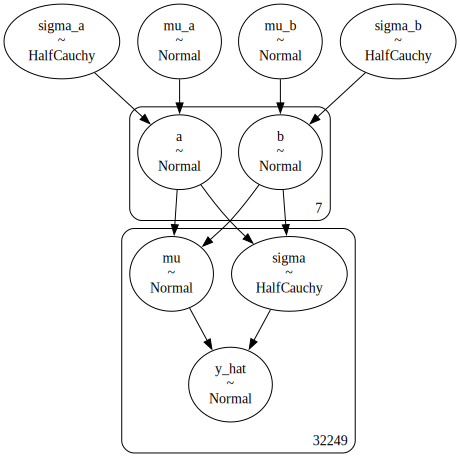

In [159]:
# Graph the hierarchical model
pm.model_to_graphviz(hierarchical_numeric_model)

In [153]:
# Variational inference with ADVI optimization
advi_hierarchical_fit = pm.fit(50000, method='advi', model = hierarchical_numeric_model)

Finished [100%]: Average Loss = 138.92


## Model: Are they a good pick for my fantasy team? Yes or no

In [163]:
stats

,RANK,NAME,TEAM,AGE,GP,MPG,MIN%,USG%,TO%,FTA,FT%,2PA,2P%,3PA,3P%,eFG%,TS%,PPG,RPG,TRB%,APG,AST%,SPG,BPG,TOPG,VI,ORTG,DRTG,game_id,player_id,starter,mp,did_not_play,is_inactive,fantasy_points,POSITION,opponent,teamscore,opponentscore,date,avg_pts,team_rank,conference,position_id
0,0,Precious Achiuwa,MIA,21.66,61,12.1,25.2,19.5,13.5,110,0.509,227,0.546,1,0.00,0.544,0.550,5.0,3.4,16.1,0.5,6.1,0.33,0.46,0.70,6.7,106.8,99.7,202101200TOR,achiupr01,0,14.24,0,0,12.8,F,MIA,102,111,120,12.800000,12,0,0
1,0,Precious Achiuwa,MIA,21.66,61,12.1,25.2,19.5,13.5,110,0.509,227,0.546,1,0.00,0.544,0.550,5.0,3.4,16.1,0.5,6.1,0.33,0.46,0.70,6.7,106.8,99.7,202101220TOR,achiupr01,0,11.32,0,0,10.7,F,MIA,101,81,122,12.800000,12,0,0
2,0,Precious Achiuwa,MIA,21.66,61,12.1,25.2,19.5,13.5,110,0.509,227,0.546,1,0.00,0.544,0.550,5.0,3.4,16.1,0.5,6.1,0.33,0.46,0.70,6.7,106.8,99.7,202102240MIA,achiupr01,0,6.00,0,0,3.4,F,MIA,108,116,224,11.750000,12,0,0
3,0,Precious Achiuwa,MIA,21.66,61,12.1,25.2,19.5,13.5,110,0.509,227,0.546,1,0.00,0.544,0.550,5.0,3.4,16.1,0.5,6.1,0.33,0.46,0.70,6.7,106.8,99.7,202110200TOR,achiupr01,1,18.30,0,0,18.4,F,WAS,83,98,1020,8.966667,12,0,0
4,0,Precious Achiuwa,MIA,21.66,61,12.1,25.2,19.5,13.5,110,0.509,227,0.546,1,0.00,0.544,0.550,5.0,3.4,16.1,0.5,6.1,0.33,0.46,0.70,6.7,106.8,99.7,202110220BOS,achiupr01,1,24.50,0,0,35.0,F,BOS,115,83,1022,11.325000,12,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32244,625,Ivica Zubac,LAC,24.16,72,22.3,46.5,15.2,14.7,171,0.789,390,0.656,4,0.25,0.654,0.693,9.0,7.2,18.1,1.3,7.9,0.33,0.86,1.13,7.9,134.5,101.0,202112200LAC,zubaciv01,1,27.21,0,0,31.9,C,SAS,92,116,1220,20.970000,4,1,1
32245,625,Ivica Zubac,LAC,24.16,72,22.3,46.5,15.2,14.7,171,0.789,390,0.656,4,0.25,0.654,0.693,9.0,7.2,18.1,1.3,7.9,0.33,0.86,1.13,7.9,134.5,101.0,202112220SAC,zubaciv01,1,26.39,0,0,22.2,C,SAC,105,89,1222,23.180000,4,1,1
32246,625,Ivica Zubac,LAC,24.16,72,22.3,46.5,15.2,14.7,171,0.789,390,0.656,4,0.25,0.654,0.693,9.0,7.2,18.1,1.3,7.9,0.33,0.86,1.13,7.9,134.5,101.0,202112260LAC,zubaciv01,1,27.22,0,0,36.2,C,DEN,100,103,1226,22.760000,4,1,1
32247,625,Ivica Zubac,LAC,24.16,72,22.3,46.5,15.2,14.7,171,0.789,390,0.656,4,0.25,0.654,0.693,9.0,7.2,18.1,1.3,7.9,0.33,0.86,1.13,7.9,134.5,101.0,202112270LAC,zubaciv01,1,21.45,0,0,19.3,C,BRK,108,124,1227,24.130000,4,1,1


Exploratory Data Analysis: To figure out what constitutes a "good" pick

In [170]:
stats.VI.describe()

count    32249.000000
mean         7.340454
std          2.173221
min          0.000000
25%          5.900000
50%          7.200000
75%          8.400000
max         15.800000
Name: VI, dtype: float64

In [175]:
stats.avg_pts.describe()

count    32249.000000
mean        17.393728
std         12.533829
min         -1.000000
25%          7.000000
50%         16.040000
75%         25.090000
max         72.800000
Name: avg_pts, dtype: float64

In [177]:
# Data frame of the top players, based on versatality index
elite = stats[stats['VI'] >= 8]
len(elite.NAME.unique())

142

In [184]:
high = elite[elite['avg_pts']>= 24]
print('Number of "good" players: ', len(high.NAME.unique()))
print('Total # players in dataset: ', len(stats.NAME.unique()))

Number of "good" players:  107
Total # players in dataset:  442


In [185]:
# New variable: good pick (1 or 0)

pick = []
for i in range(n): 
    if (stats['VI'][i] >= 8) and (stats['avg_pts'][i] >= 24):
        pick.append(1)
    else:
        pick.append(0)
stats['good_pick'] = pick

In [189]:
stats[stats['good_pick'] == 1]

,RANK,NAME,TEAM,AGE,GP,MPG,MIN%,USG%,TO%,FTA,FT%,2PA,2P%,3PA,3P%,eFG%,TS%,PPG,RPG,TRB%,APG,AST%,SPG,BPG,TOPG,VI,ORTG,DRTG,game_id,player_id,starter,mp,did_not_play,is_inactive,fantasy_points,POSITION,opponent,teamscore,opponentscore,date,avg_pts,team_rank,conference,position_id,good_pick
66,3,Bam Adebayo,MIA,23.83,64,33.5,69.7,23.7,15.0,354,0.799,792,0.573,8,0.250,0.571,0.626,18.7,9.0,15.3,5.4,26.9,1.17,1.03,2.64,11.6,121.7,105.0,202101010DAL,adebaba01,1,36.29,0,0,40.2,C,DAL,83,93,101,40.20,6,0,1,1
67,3,Bam Adebayo,MIA,23.83,64,33.5,69.7,23.7,15.0,354,0.799,792,0.573,8,0.250,0.571,0.626,18.7,9.0,15.3,5.4,26.9,1.17,1.03,2.64,11.6,121.7,105.0,202101040MIA,adebaba01,1,28.24,0,0,34.6,C,OKC,118,90,104,40.20,6,0,1,1
68,3,Bam Adebayo,MIA,23.83,64,33.5,69.7,23.7,15.0,354,0.799,792,0.573,8,0.250,0.571,0.626,18.7,9.0,15.3,5.4,26.9,1.17,1.03,2.64,11.6,121.7,105.0,202101060MIA,adebaba01,1,33.45,0,0,41.6,C,BOS,105,107,106,37.40,6,0,1,1
69,3,Bam Adebayo,MIA,23.83,64,33.5,69.7,23.7,15.0,354,0.799,792,0.573,8,0.250,0.571,0.626,18.7,9.0,15.3,5.4,26.9,1.17,1.03,2.64,11.6,121.7,105.0,202101090WAS,adebaba01,1,21.26,0,0,32.2,C,WAS,128,124,109,38.80,6,0,1,1
70,3,Bam Adebayo,MIA,23.83,64,33.5,69.7,23.7,15.0,354,0.799,792,0.573,8,0.250,0.571,0.626,18.7,9.0,15.3,5.4,26.9,1.17,1.03,2.64,11.6,121.7,105.0,202101120PHI,adebaba01,0,0.00,1,0,0.0,C,PHI,134,137,112,37.15,6,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32098,623,Trae Young,ATL,22.66,63,33.7,70.3,33.0,16.2,546,0.886,715,0.491,397,0.343,0.499,0.589,25.3,3.9,6.3,9.4,45.5,0.84,0.17,4.14,11.6,116.9,111.9,202112150ORL,youngtr01,1,30.23,0,0,41.8,PG,ORL,111,99,1215,49.75,5,0,5,1
32099,623,Trae Young,ATL,22.66,63,33.7,70.3,33.0,16.2,546,0.886,715,0.491,397,0.343,0.499,0.589,25.3,3.9,6.3,9.4,45.5,0.84,0.17,4.14,11.6,116.9,111.9,202112170ATL,youngtr01,1,33.56,0,0,52.6,PG,DEN,115,133,1217,49.55,5,0,5,1
32100,623,Trae Young,ATL,22.66,63,33.7,70.3,33.0,16.2,546,0.886,715,0.491,397,0.343,0.499,0.589,25.3,3.9,6.3,9.4,45.5,0.84,0.17,4.14,11.6,116.9,111.9,202112270ATL,youngtr01,1,39.47,0,0,41.7,PG,CHI,118,130,1227,49.02,5,0,5,1
32101,623,Trae Young,ATL,22.66,63,33.7,70.3,33.0,16.2,546,0.886,715,0.491,397,0.343,0.499,0.589,25.3,3.9,6.3,9.4,45.5,0.84,0.17,4.14,11.6,116.9,111.9,202112290CHI,youngtr01,1,33.18,0,0,39.1,PG,CHI,117,131,1229,48.87,5,0,5,1


In [193]:
# Numeric preds
numeric_predictors = [['AGE', 'GP', 'MPG', 'MIN%', 'USG%', 'TO%', 'FTA', 'FT%', '2PA', '2P%', '3PA', '3P%', 'eFG%', 'TS%', 'PPG', 'RPG', 'TRB%', 'APG', 'AST%', 'SPG', 'BPG', 'TOPG', 'VI', 'ORTG', 'DRTG', 'starter', 'mp', 'did_not_play', 'is_inactive', 'fantasy_points', 'teamscore', 'opponentscore', 'avg_pts', 'team_rank', 'conference']]

# Number of player-game observations
n = stats.shape[0]

# Grouped variable
position = stats['POSITION']

positions = stats['POSITION'].unique()
npositions = len(positions)

# "Observed" variable
good_pick = stats['good_pick']

# Predictor variables
min_percent = stats['MIN%']
mp = stats['mp'] #minutes played in a certain game
avg_f_pts = stats['avg_pts']
team_rank = stats['team_rank']
ppg = stats['PPG']
efg = stats['eFG%'] #effective shooting percentage
vi = stats['VI'] #versitality index
ortg = stats['ORTG'] #offensive rating
ft = stats['FT%']
age = stats['AGE']

opp = stats['opponent']

# Lookup table for each position
pos_lookup = dict(zip(positions, range(npositions)))

def set_ranks(row_number, assigned_value):
    return assigned_value[row_number]
ids ={'F': 0, 'C': 1, 'SG': 2, 'PF': 3, 'SF': 4, 'PG': 5, 'G': 6}
stats['position_id'] = stats['POSITION'].apply(set_ranks, args =(ids, ))
position = stats['position_id'] #position holds the numeric identifiers for the positions

In [194]:
# Full Hierarchical Model

with pm.Model() as hierarchical_model:

    # Priors for the model parameters
    # Gaussians for the means of the priors of the random intercepts and slopes
    mu_a = pm.Normal('mu_a', mu=0., sigma=1e5)
    mu_b = pm.Normal('mu_b', mu=0., sigma=1e5)
    
    # Half-Cauchy for the standard deviations of the priors 
    # of the random intercepts and slopes
    sigma_a =  pm.HalfCauchy('sigma_a', 1e5)
    sigma_b =  pm.HalfCauchy('sigma_b', 1e5)

    # Gaussian priors for random intercepts and slopes
    a = pm.Normal('a', mu=mu_a, sigma=sigma_a, shape=npositions)
    b = pm.Normal('b', mu=mu_b, sigma=sigma_b, shape=npositions)
    
    # Linear model
    μ = a[position] + b[position]*min_percent + b[position]*mp + b[position]*vi
    
    # Transform outcome to probability
    θ = pm.Deterministic('θ', pm.invlogit(μ))
    y_hat = pm.Bernoulli('y_hat', p=θ, observed=good_pick)
    
    # Sample the posterior
    hierarchical_trace = pm.sample(draws=1000, step=pm.NUTS(target_accept=0.99), tune=10000)

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_a, mu_b, sigma_a, sigma_b, a, b]


Sampling 2 chains for 10_000 tune and 1_000 draw iterations (20_000 + 2_000 draws total) took 9680 seconds.


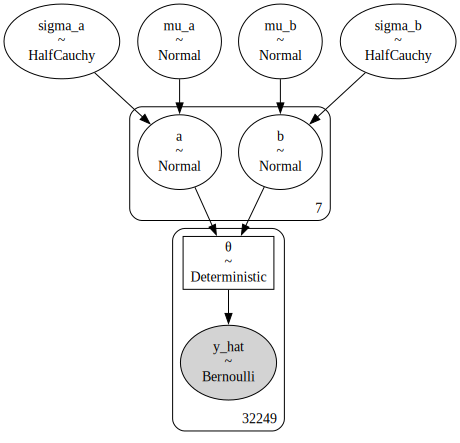

In [195]:
# Graph the hierarchical model
pm.model_to_graphviz(hierarchical_model)

## Model: Plus or Minus vs. expected?

In [200]:
bball = pd.read_csv('Use_This_WithPM.csv')
bball

,Unnamed: 0,game_id,player_id,starter,mp,did_not_play,is_inactive,plus_minus,fantasy_points,player_name,position,team,opponent,teamscore,opponentscore,date,avg_pts,good_bad
0,321,202201020TOR,achiupr01,0,18:17,0,0,4,11.5,Precious Achiuwa,F,TOR,NYK,120,105,102,11.500,1
1,706,202201040TOR,achiupr01,0,18:44,0,0,15,18.3,Precious Achiuwa,F,TOR,SAS,129,104,104,11.500,1
2,863,202201050MIL,achiupr01,0,16:00,0,0,3,22.1,Precious Achiuwa,F,TOR,MIL,117,111,105,14.900,1
3,1336,202201070TOR,achiupr01,0,17:41,0,0,14,19.0,Precious Achiuwa,F,TOR,UTA,122,108,107,17.300,1
4,1748,202201090TOR,achiupr01,0,27:03,0,0,12,21.8,Precious Achiuwa,F,TOR,NOP,105,101,109,17.725,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13198,15758,202204010MIL,zubaciv01,1,21:14,0,0,22,22.6,Ivica Zubac,C,LAC,MIL,153,119,401,27.350,1
13199,16093,202204030LAC,zubaciv01,1,24:59,0,0,3,35.3,Ivica Zubac,C,LAC,NOP,119,100,403,27.030,1
13200,16702,202204060LAC,zubaciv01,1,25:13,0,0,14,29.7,Ivica Zubac,C,LAC,PHO,113,109,406,25.620,1
13201,17178,202204090LAC,zubaciv01,1,24:32,0,0,9,32.4,Ivica Zubac,C,LAC,SAC,117,98,409,25.040,1


In [201]:
# Team rank for 20-2021 season - two teams for each val (bc seperated by E & W conferences)

# Fx to map the values
def set_ranks(row_number, assigned_value):
    return assigned_value[row_number]
 
# Create the dictionary
ranks ={'PHI':1,
        'BRK':2,
        'MIL':3,
        'NYK':4,
        'ATL':5,
        'MIA':6,
        'BOS':7,
        'WAS':8,
        'IND':9,
        'CHO':10,
        'CHI':11,
        'TOR':12, 
        'CLE':13,
        'ORL':14,
        'DET':15,
        
        'UTA':1,
        'PHO':2,
        'DEN':3,
        'LAC':4,
        'DAL':5,
        'POR':6,
        'LAL':7,
        'MEM':8, 
        'GSW':9,
        'SAS':10,
        'NOP':11, 
        'SAC':12,
        'MIN':13,
        'OKC':14,
        'HOU':15
        }
 
# Add a new col
bball['team_rank'] = bball['team'].apply(set_ranks, args =(ranks, ))

In [202]:
# Conference
# 0 for East, 1 for West

bball['conference'] = [0 if x =='PHI' or x =='BRK' or x =='MIL' or x =='NYK' or x =='ATL' or x =='MIA' or x =='BOS' or x =='WAS' or x =='IND' or x =='CHO' or x =='CHI' or x =='TOR' or x =='CLE' or x =='ORL' or x =='DET' else 1 for x in bball['team']]

In [203]:
# Change var name for easier join

bball = bball.rename(columns={'player_name':'NAME'})

In [219]:
# Import box stats data (source: https://www.nbastuffer.com/2020-2021-nba-player-stats/) (20-21 season)

box_stats = pd.read_excel('21reg_season.xlsx', header=1).reset_index()

In [222]:
box_stats = box_stats.drop(columns='RANK')

In [223]:
box_stats = box_stats.rename(columns={'FULL NAME':'NAME',
                                      'index':'RANK', 
                                      'MIN%Minutes PercentagePercentage of team minutes used by a player while he was on the floor':'MIN%',
                                      'USG%Usage RateUsage rate, a.k.a., usage percentage is an estimate of the percentage of team plays used by a player while he was on the floor':'USG%',
                                       'TO%Turnover RateA metric that estimates the number of turnovers a player commits per 100 possessions':'TO%',
                                       'eFG%Effective Shooting PercentageWith eFG%, three-point shots made are worth 50% more than two-point shots made. eFG% Formula=(FGM+ (0.5 x 3PM))/FGA':'eFG%',
                                       'TS%True Shooting PercentageTrue shooting percentage is a measure of shooting efficiency that takes into account field goals, 3-point field goals, and free throws.':'TS%',
                                       'PPGPointsPoints per game.':'PPG', 
                                       'RPGReboundsRebounds per game.':'RPG',
                                       'TRB%Total Rebound PercentageTotal rebound percentage is estimated percentage of available rebounds grabbed by the player while the player is on the court.':'TRB%',
                                       'APGAssistsAssists per game.':'APG',
                                       'AST%Assist PercentageAssist percentage is an estimated percentage of teammate field goals a player assisted while the player is on the court':'AST%',
                                       'SPGStealsSteals per game.':'SPG', 
                                       'BPGBlocksBlocks per game.':'BPG',
                                       'TOPGTurnoversTurnovers per game.':'TOPG',
                                       'VIVersatility IndexVersatility index is a metric that measures a player’s ability to produce in points, assists, and rebounds. The average player will score around a five on the index, while top players score above 10':'VI',
                                       'ORTGOffensive RatingIndividual offensive rating is the number of points produced by a player per 100 total individual possessions.':'ORTG',
                                       'DRTGDefensive RatingIndividual defensive rating estimates how many points the player allowed per 100 possessions he individually faced while staying on the court.':'DRTG'})

In [224]:
# Make teams all caps for an easier join

box_stats['TEAM'] = box_stats['TEAM'].str.upper()

In [225]:
box_stats

,RANK,NAME,TEAM,POS,AGE,GP,MPG,MIN%,USG%,TO%,FTA,FT%,2PA,2P%,3PA,3P%,eFG%,TS%,PPG,RPG,TRB%,APG,AST%,SPG,BPG,TOPG,VI,ORTG,DRTG
0,0,Precious Achiuwa,MIA,F,21.66,61,12.1,25.2,19.5,13.5,110,0.509,227,0.546,1,0.000,0.544,0.550,5.0,3.4,16.1,0.5,6.1,0.33,0.46,0.70,6.7,106.8,99.7
1,1,Jaylen Adams,MIL,G,25.03,7,2.6,5.4,18.5,0.0,0,0.000,6,0.167,2,0.000,0.125,0.125,0.3,0.4,8.7,0.3,12.6,0.00,0.00,0.00,5.1,NaN,NaN
2,2,Steven Adams,NOR,C,27.83,58,27.7,57.6,11.7,17.7,135,0.444,305,0.620,3,0.000,0.614,0.596,7.6,8.9,17.4,1.9,9.1,0.93,0.66,1.36,7.3,119.7,107.8
3,3,Bam Adebayo,MIA,C-F,23.83,64,33.5,69.7,23.7,15.0,354,0.799,792,0.573,8,0.250,0.571,0.626,18.7,9.0,15.3,5.4,26.9,1.17,1.03,2.64,11.6,121.7,105.0
4,4,LaMarcus Aldridge,SAN,C-F,35.83,21,25.9,54.0,22.7,7.0,37,0.838,173,0.509,75,0.360,0.518,0.545,13.7,4.5,9.2,1.7,10.2,0.38,0.86,0.95,7.3,107.3,110.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
621,621,Delon Wright,SAC,G,29.06,27,25.8,53.7,17.1,12.7,36,0.833,142,0.500,83,0.398,0.536,0.563,10.0,3.9,8.4,3.6,18.9,1.56,0.37,1.30,8.1,114.9,115.4
622,622,Thaddeus Young,CHI,F,32.90,68,24.3,50.6,22.3,16.0,113,0.628,618,0.579,45,0.267,0.567,0.577,12.1,6.2,14.1,4.3,27.1,1.09,0.59,2.00,11.3,115.3,104.5
623,623,Trae Young,ATL,G,22.66,63,33.7,70.3,33.0,16.2,546,0.886,715,0.491,397,0.343,0.499,0.589,25.3,3.9,6.3,9.4,45.5,0.84,0.17,4.14,11.6,116.9,111.9
624,624,Cody Zeller,CHA,F-C,28.61,48,20.9,43.6,18.3,11.9,119,0.714,296,0.598,28,0.143,0.565,0.599,9.4,6.8,17.7,1.8,13.2,0.56,0.35,1.06,9.3,121.8,101.5


#### NEW DATAFRAME!

In [226]:
# Join the two dataframes on the player name

stats = box_stats.merge(bball, on='NAME', how='inner')

In [227]:
stats = stats.drop(columns=['Unnamed: 0', 'team'])

In [228]:
# Convert time to something we can work with
stats['mp'] = stats['mp'].str.replace(':', '.')

In [229]:
stats['mp'] = pd. to_numeric(stats['mp']) 

In [230]:
# We only want one position column

stats = stats.drop(columns='POS')

In [231]:
stats = stats.rename(columns={'position':'POSITION'})

In [232]:
box_stats = box_stats.drop(columns='RANK')

In [234]:
stats

,RANK,NAME,TEAM,AGE,GP,MPG,MIN%,USG%,TO%,FTA,FT%,2PA,2P%,3PA,3P%,eFG%,TS%,PPG,RPG,TRB%,APG,AST%,SPG,BPG,TOPG,VI,ORTG,DRTG,game_id,player_id,starter,mp,did_not_play,is_inactive,plus_minus,fantasy_points,POSITION,opponent,teamscore,opponentscore,date,avg_pts,good_bad,team_rank,conference
0,0,Precious Achiuwa,MIA,21.66,61,12.1,25.2,19.5,13.5,110,0.509,227,0.546,1,0.00,0.544,0.550,5.0,3.4,16.1,0.5,6.1,0.33,0.46,0.70,6.7,106.8,99.7,202201020TOR,achiupr01,0,18.17,0,0,4,11.5,F,NYK,120,105,102,11.500,1,12,0
1,0,Precious Achiuwa,MIA,21.66,61,12.1,25.2,19.5,13.5,110,0.509,227,0.546,1,0.00,0.544,0.550,5.0,3.4,16.1,0.5,6.1,0.33,0.46,0.70,6.7,106.8,99.7,202201040TOR,achiupr01,0,18.44,0,0,15,18.3,F,SAS,129,104,104,11.500,1,12,0
2,0,Precious Achiuwa,MIA,21.66,61,12.1,25.2,19.5,13.5,110,0.509,227,0.546,1,0.00,0.544,0.550,5.0,3.4,16.1,0.5,6.1,0.33,0.46,0.70,6.7,106.8,99.7,202201050MIL,achiupr01,0,16.00,0,0,3,22.1,F,MIL,117,111,105,14.900,1,12,0
3,0,Precious Achiuwa,MIA,21.66,61,12.1,25.2,19.5,13.5,110,0.509,227,0.546,1,0.00,0.544,0.550,5.0,3.4,16.1,0.5,6.1,0.33,0.46,0.70,6.7,106.8,99.7,202201070TOR,achiupr01,0,17.41,0,0,14,19.0,F,UTA,122,108,107,17.300,1,12,0
4,0,Precious Achiuwa,MIA,21.66,61,12.1,25.2,19.5,13.5,110,0.509,227,0.546,1,0.00,0.544,0.550,5.0,3.4,16.1,0.5,6.1,0.33,0.46,0.70,6.7,106.8,99.7,202201090TOR,achiupr01,0,27.03,0,0,12,21.8,F,NOP,105,101,109,17.725,1,12,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12903,625,Ivica Zubac,LAC,24.16,72,22.3,46.5,15.2,14.7,171,0.789,390,0.656,4,0.25,0.654,0.693,9.0,7.2,18.1,1.3,7.9,0.33,0.86,1.13,7.9,134.5,101.0,202204010MIL,zubaciv01,1,21.14,0,0,22,22.6,C,MIL,153,119,401,27.350,1,4,1
12904,625,Ivica Zubac,LAC,24.16,72,22.3,46.5,15.2,14.7,171,0.789,390,0.656,4,0.25,0.654,0.693,9.0,7.2,18.1,1.3,7.9,0.33,0.86,1.13,7.9,134.5,101.0,202204030LAC,zubaciv01,1,24.59,0,0,3,35.3,C,NOP,119,100,403,27.030,1,4,1
12905,625,Ivica Zubac,LAC,24.16,72,22.3,46.5,15.2,14.7,171,0.789,390,0.656,4,0.25,0.654,0.693,9.0,7.2,18.1,1.3,7.9,0.33,0.86,1.13,7.9,134.5,101.0,202204060LAC,zubaciv01,1,25.13,0,0,14,29.7,C,PHO,113,109,406,25.620,1,4,1
12906,625,Ivica Zubac,LAC,24.16,72,22.3,46.5,15.2,14.7,171,0.789,390,0.656,4,0.25,0.654,0.693,9.0,7.2,18.1,1.3,7.9,0.33,0.86,1.13,7.9,134.5,101.0,202204090LAC,zubaciv01,1,24.32,0,0,9,32.4,C,SAC,117,98,409,25.040,1,4,1


## PARTIAL POOLED MODEL

In [246]:
X = np.zeros(shape = (stats.shape[0], npositions))
for i, pos in enumerate(positions):
    X[:, i] = (position == pos)

In [259]:
# Sampling approach with HMC
# Set up partial pooling model
with pm.Model() as partial_pooling:

    # Priors
    mu_a = pm.Normal('mu_a', mu=0., sigma=1e5)
    sigma_a = pm.HalfCauchy('sigma_a', 5)

    # Random intercepts
    a = pm.Normal('a', mu=mu_a, sigma=sigma_a, shape=npositions)
    
    # Expected value
    y_hat = pm.math.dot(a, X.T)

    # Data likelihood
    y_like = pm.Bernoulli('y_like', logit_p=y_hat, observed=good_bad)

    # Run sampling
    trace_pp = pm.sample(10000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_a, sigma_a, a]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 293 seconds.


In [260]:
# Variational inference with ADVI optimization
advi_fit_pp = pm.fit(50000, method = 'advi', model = partial_pooling)

Finished [100%]: Average Loss = 8,959.8


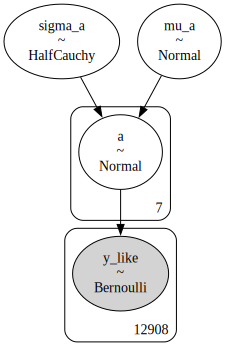

In [261]:
# Graphically display the model used for both 
# - HMC sampling
# - variational inference with ADVI optimization
# The two models are in different variables, but structured identically. See above code.
pm.model_to_graphviz(partial_pooling)

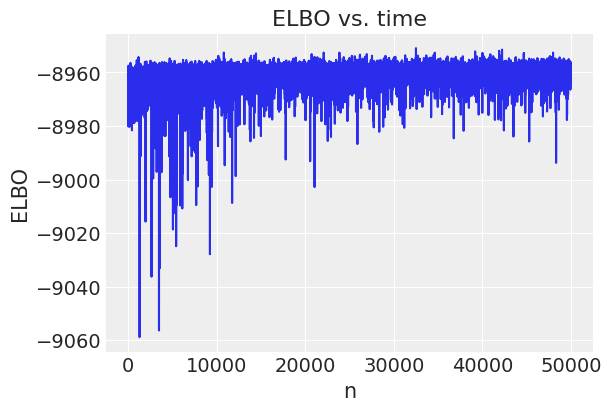

In [262]:
# plot the ELBO vs. fitting time or iterations (n)

advi_elbo = pd.DataFrame(
    {'ELBO': -advi_fit_pp.hist,
     'n': np.arange(advi_fit_pp.hist.shape[0])})

plt.figure(dpi=100)
ax = sns.lineplot(y='ELBO', x='n', data=advi_elbo)
ax.set_title("ELBO vs. time")
plt.show()

In [263]:
# sample from the variational posterior distribution
PPC_SAMPLES = 5000
advi_fit_sample = advi_fit_pp.sample(PPC_SAMPLES)

Text(0.5, 1.0, 'Sampling 94% HDI')

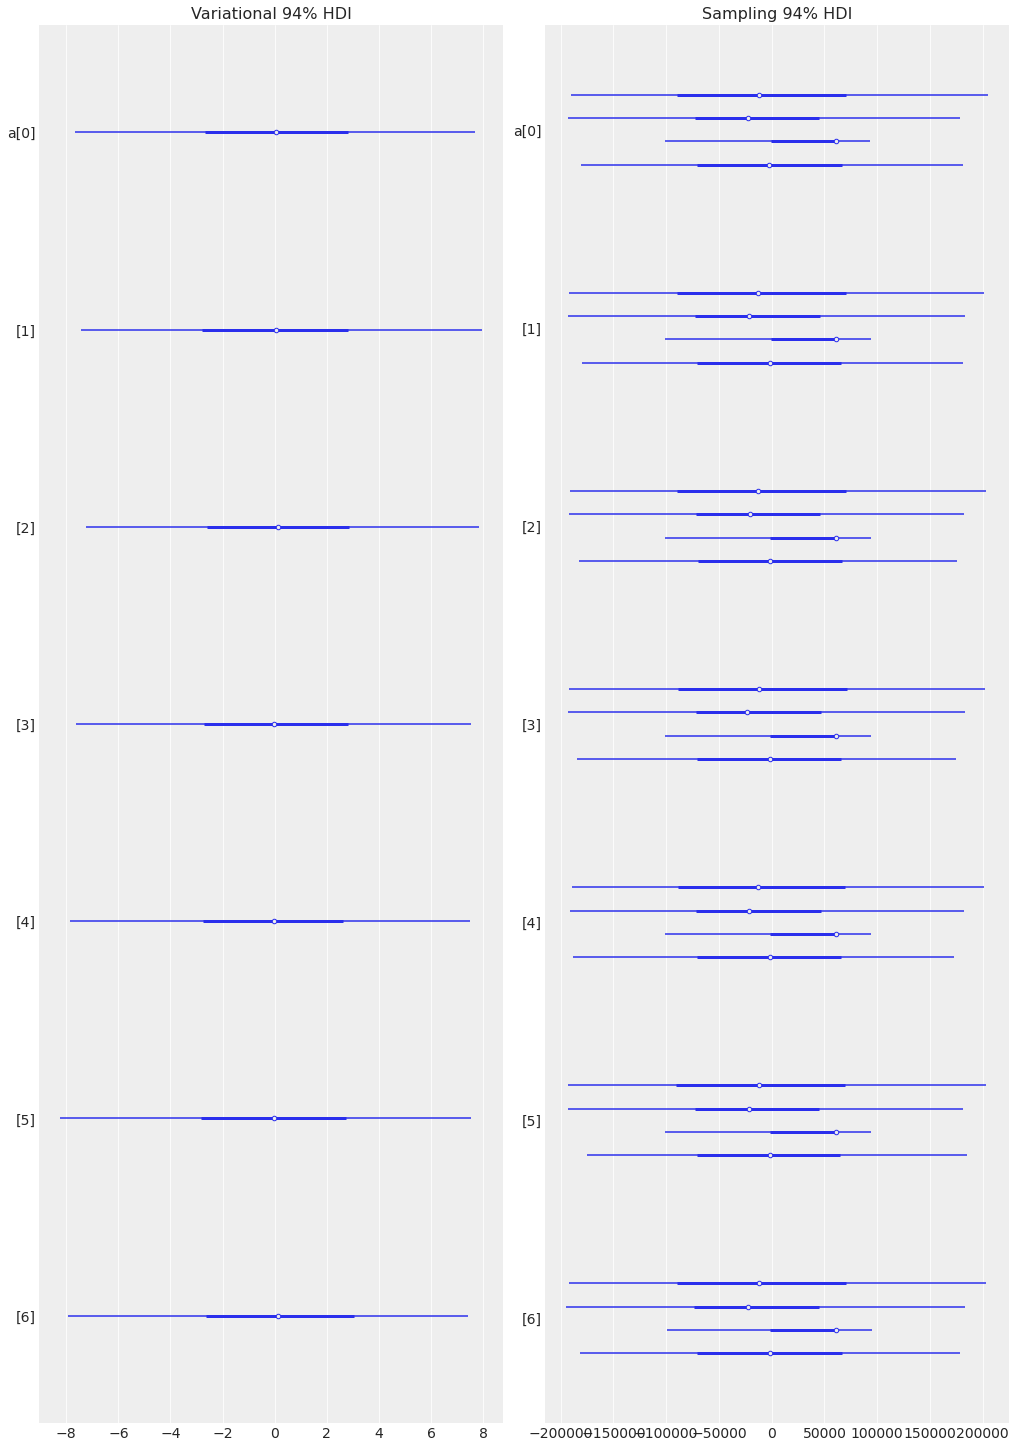

In [264]:
# Comparison of Variational and Sampling methods 
# Parameter posteriors in a forest plot

f, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize = (14,20))

pm.plot_forest(advi_fit_sample, var_names=['a'], ax = ax1)
pm.plot_forest(trace_pp, var_names=['a'], ax = ax2)
ax1.set_title('Variational 94% HDI')
ax2.set_title('Sampling 94% HDI')

In [265]:
az.summary(trace_pp, var_names=['a'], round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],2961.66,100879.08,-191462.17,163026.15,10606.02,7523.90,81.60,682.86,1.04
a[1],2998.71,102360.16,-189459.12,166329.85,10363.85,7350.37,81.40,710.52,1.04
a[2],3620.83,103244.65,-190113.91,165042.21,10398.86,7374.97,79.73,698.52,1.04
a[3],3746.14,104436.37,-188759.67,166128.24,10299.66,7303.72,80.57,727.95,1.04
a[4],3382.25,105016.50,-189262.60,164077.69,10323.72,7320.65,82.69,707.09,1.04
a[5],3032.18,103104.86,-189546.35,166660.96,10499.93,7447.14,80.32,701.17,1.04
a[6],2735.45,107034.16,-190840.61,165341.72,10254.95,7270.85,81.75,741.85,1.04


KeyError: 'a'

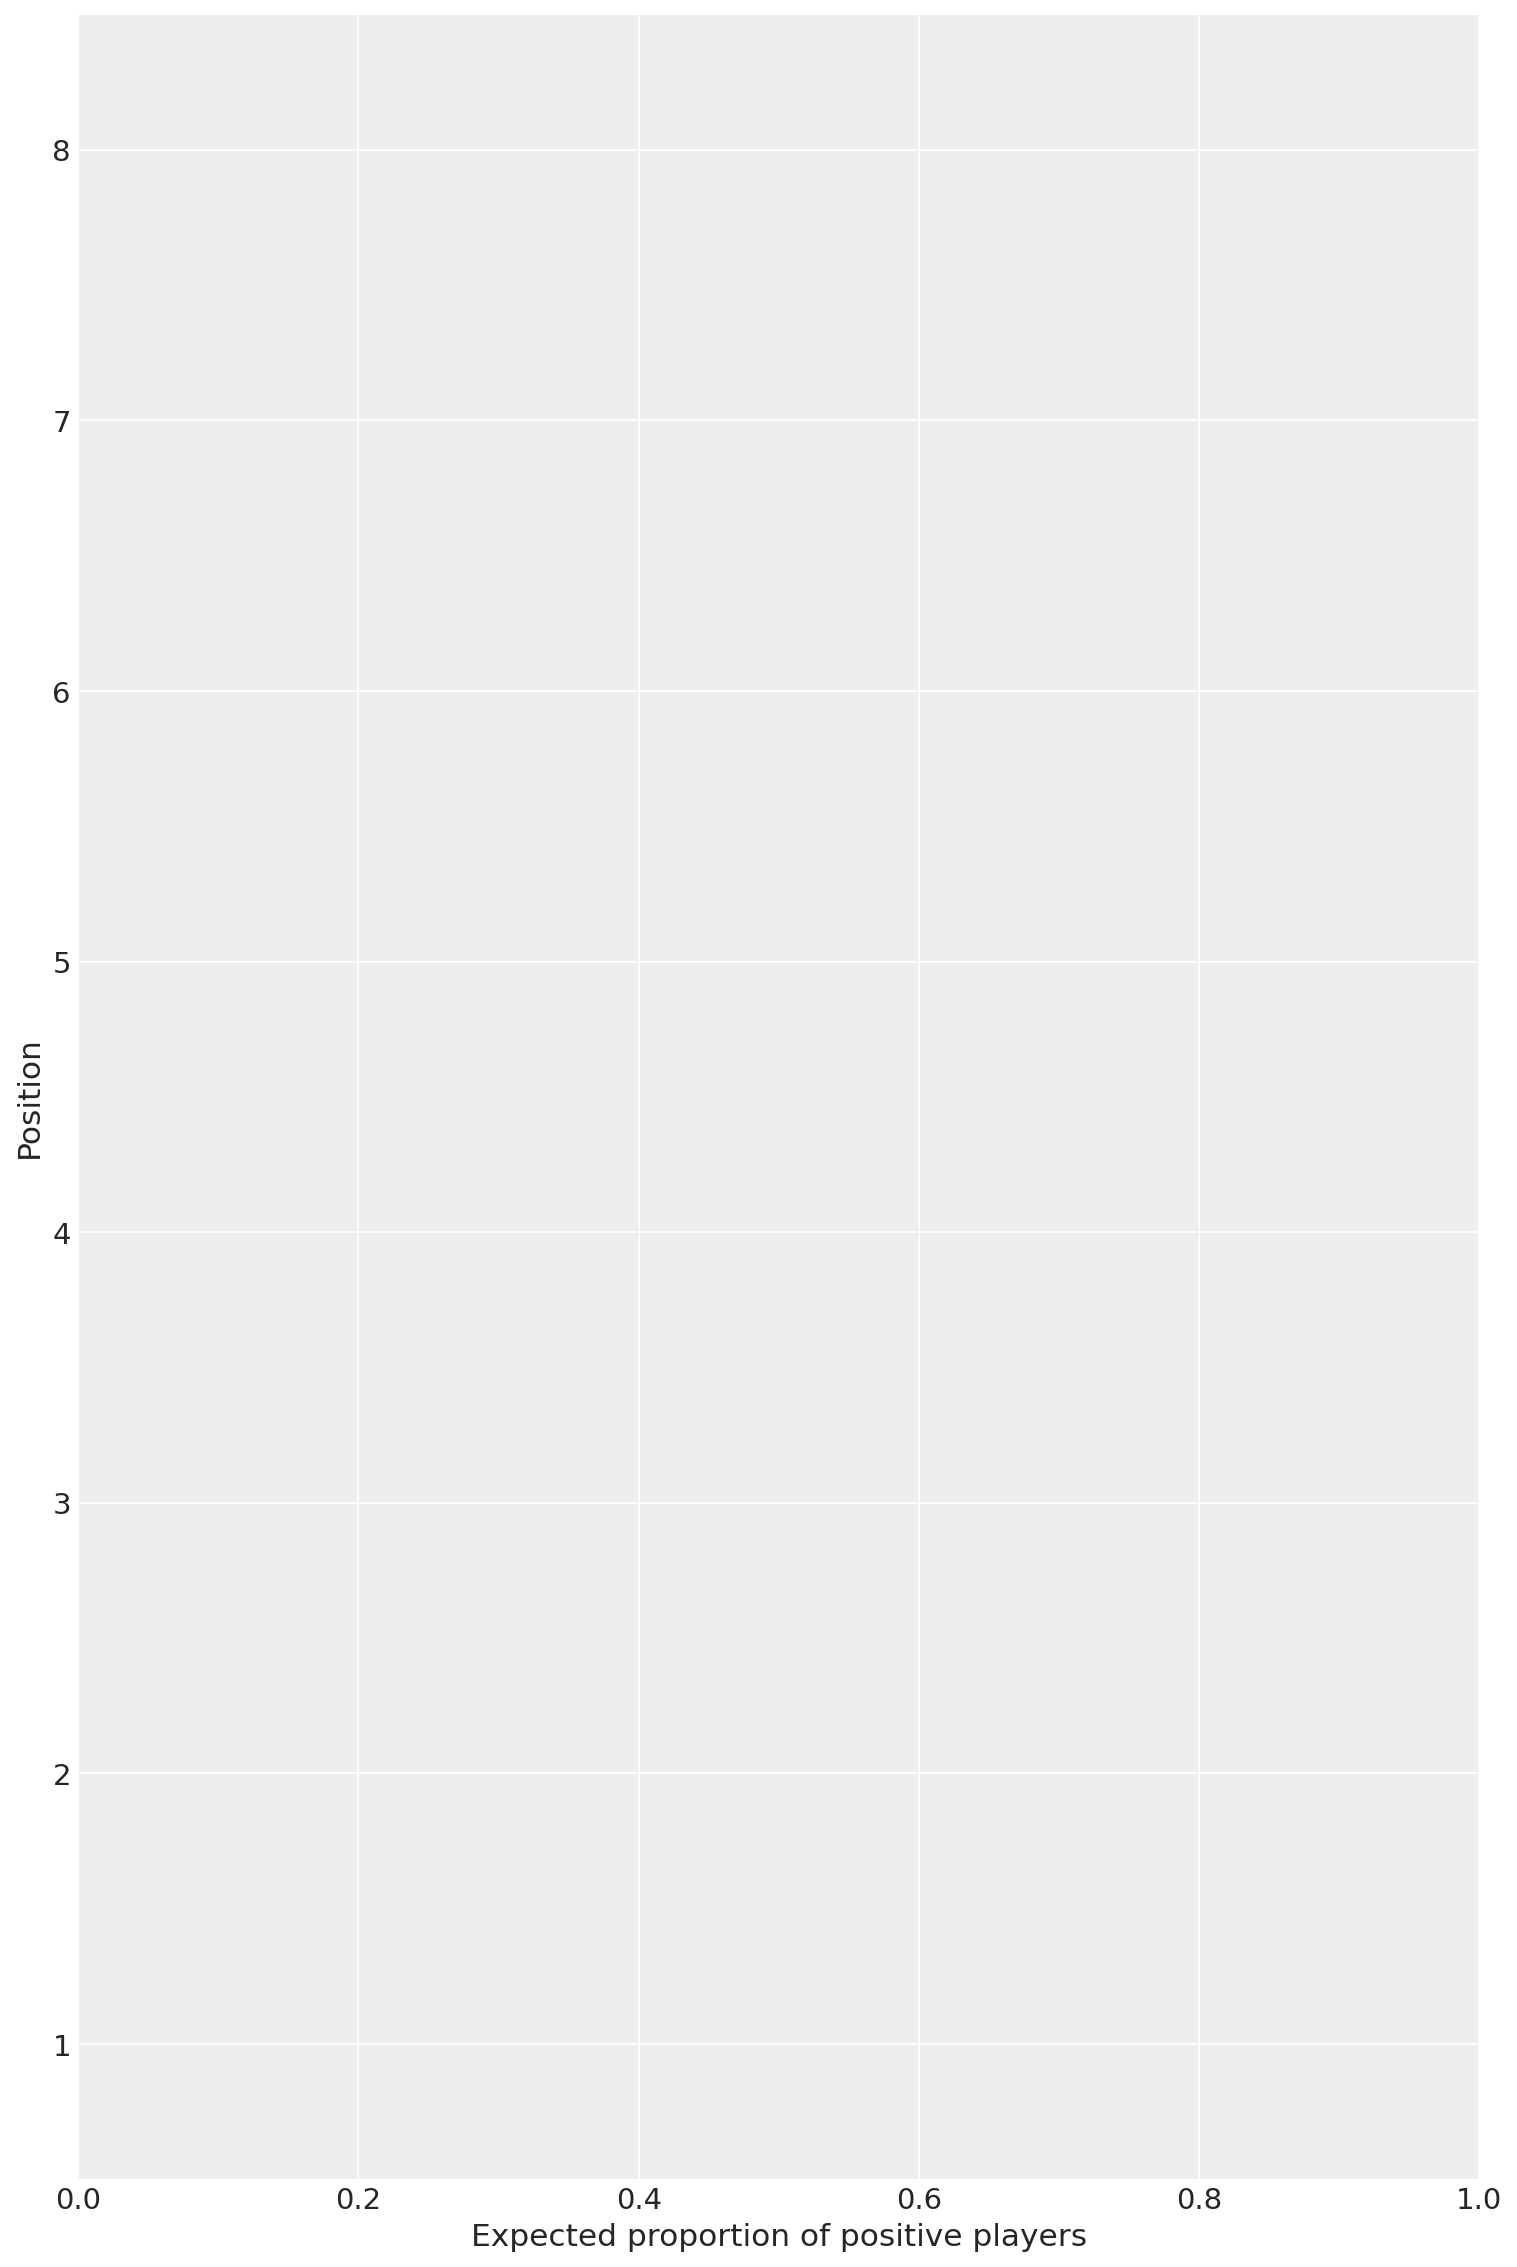

In [266]:
def invlogit(x):
    return np.exp(x) / (1 + np.exp(x))

# "Nicer" plot, generated manually.
# Also converts logits to probabilities for better interpretability.

plt.figure(figsize=(10, 15), dpi=150)

plt.yticks(range(1, npositions+2))
plt.ylim((.5, npositions+1.5))
plt.xlim((0,1))
plt.ylabel("Position")
plt.xlabel("Expected proportion of positive players")

# Plot the HMC sampling estimates
p = trace_pp['a'].mean(axis=0)
p = invlogit(p)
plt.scatter(y=levels, 
            x=p,
            label="HMC Sampling",
            color='green', alpha=0.7)
# Plot their 95% confidence intervals
for i, d in enumerate(positions):
    try: p_d = trace_pp['a'][:, i]
    except Exception as e: print(e)
        
    p_d = invlogit(p_d)
    plt.plot([np.quantile(p_d, 0.025), np.quantile(p_d, 0.975)], [d-0.1]*2,
             color='green', alpha=0.3)
    
# Plot the variational inference with ADVI optimization estimates
p = advi_trace_pp['a'].mean(axis=0)
p = invlogit(p)
plt.scatter(y=levels, 
            x=p,
            label="Variational inference",
            color='red', alpha=0.7)
# Plot their 95% confidence intervals
for i, d in enumerate(positions):
    try: p_d = advi_trace_pp['a'][:, i]
    except: continue
        
    p_d = invlogit(p_d)
    plt.plot([np.quantile(p_d, 0.025), np.quantile(p_d, 0.975)], [d+0.1]*2,
             color='red', alpha=0.3)

plt.suptitle("Exepected proportion of NBA players who meet expectation, by position", fontsize=20)
plt.title("With 95% intervals", fontsize=14)
plt.tight_layout()
plt.legend()
plt.subplots_adjust(top=0.94)
plt.show()

/Users/alseekford/opt/anaconda3/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: overflow encountered in exp
  result_data = func(*input_data)
/Users/alseekford/opt/anaconda3/lib/python3.8/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


ValueError: cannot convert float NaN to integer

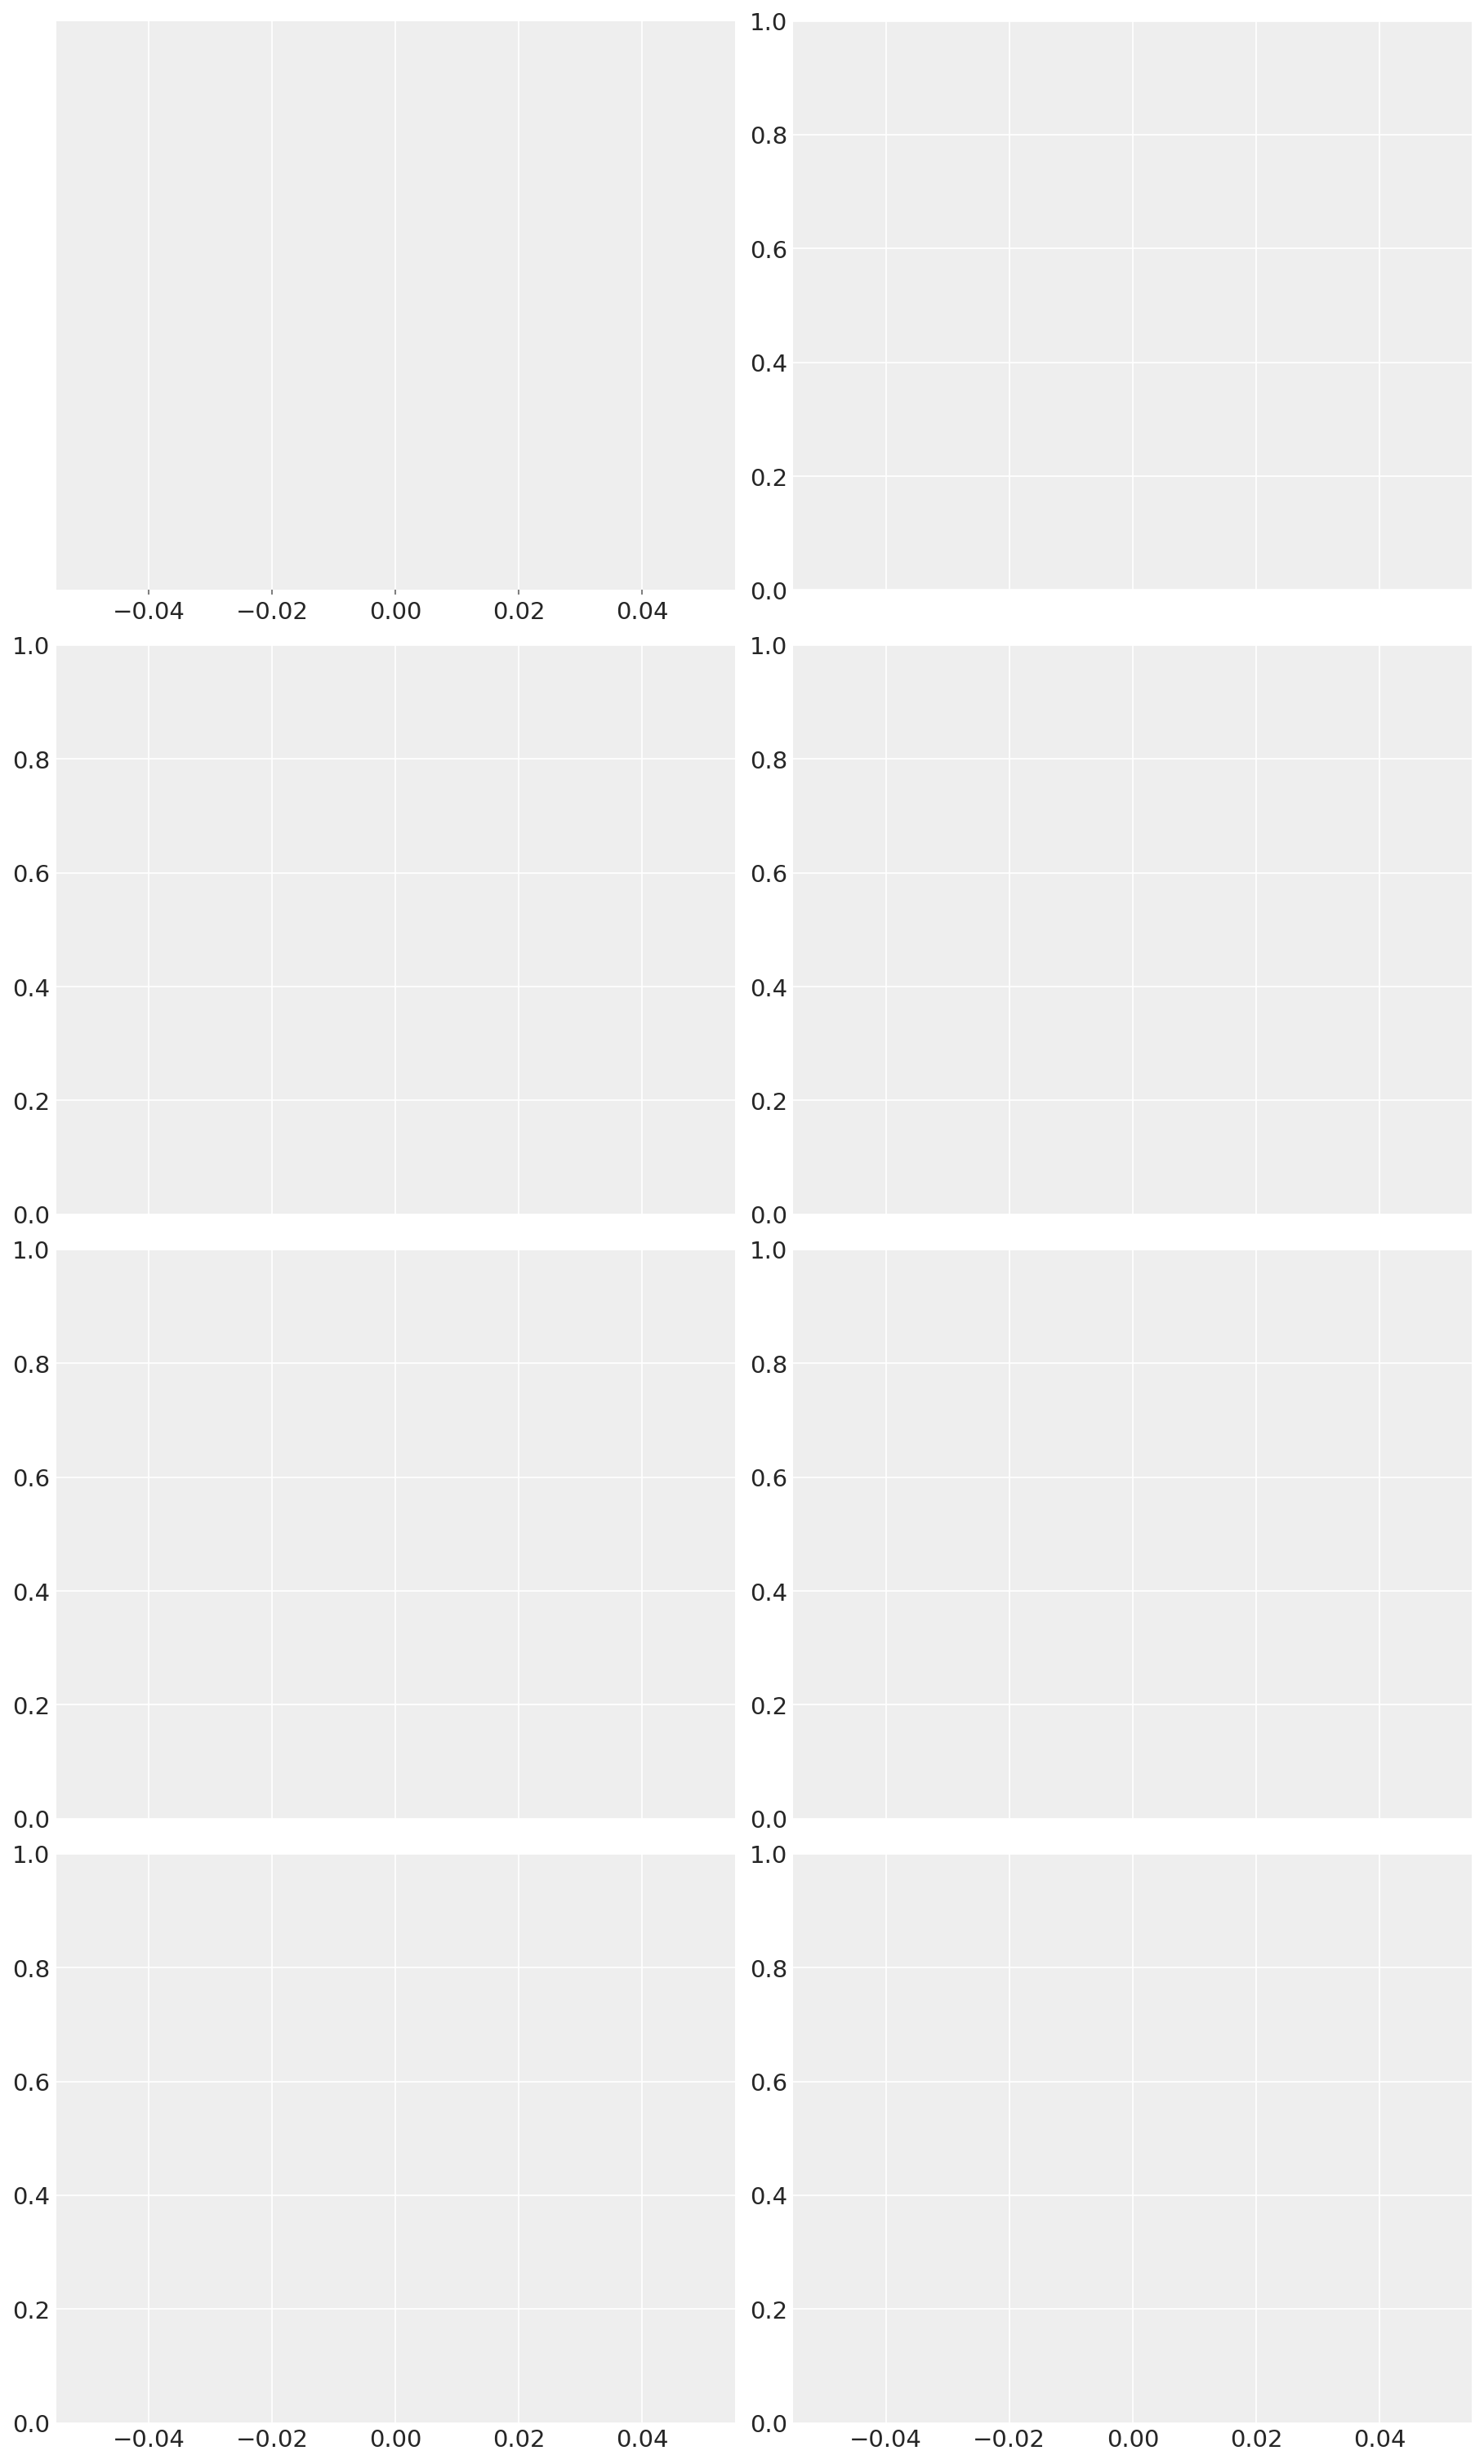

In [258]:
def invlogit(x):
    return np.exp(x) / (1 + np.exp(x))

#burnin = 1000
#sample_intercept = trace_pp.posterior['a'].mean(axis =0)[burnin:]
sample_intercept = trace_pp.posterior['a']
advi_intercept = advi_fit_sample.posterior['a']

# Plot posteriors

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 20), dpi=150, sharex=True)

for i, ax, level in zip(range(npositions), axes.ravel(), sorted(positions)):

    try:
        #pm.plot_posterior(invlogit(sample_intercept[:, i]), ax=ax, point_estimate=None, credible_interval=None, alpha=0.7)
        #pm.plot_posterior(invlogit(advi_intercept[:, i]), ax=ax, color='red', point_estimate=None, credible_interval=None, alpha=0.7)
        pm.plot_posterior(invlogit(sample_intercept[0,:,i]), ax=ax,point_estimate=None,  alpha=0.7)
        pm.plot_posterior(invlogit(advi_intercept[0,:,i]), ax=ax, color='red', point_estimate=None, hdi_prob= 'hide', alpha=0.7)
        ax.set_title("Position " + str(position), fontsize=12)
        #ax.set_xlabel("Contraception use", fontsize=12)
        ax.set_xlim((0,1))
        
    except IndexError: # one district is empty
        pass
    

plt.suptitle("Posterior Probabilities of NBA Player's PM Use\nHMC sampling in blue\nVariational inference in red")
plt.tight_layout()
plt.subplots_adjust(top=0.925)
plt.show()

In [236]:
# Numeric preds
numeric_predictors = [['AGE', 'GP', 'MPG', 'MIN%', 'USG%', 'TO%', 'FTA', 'FT%', '2PA', '2P%', '3PA', '3P%', 'eFG%', 'TS%', 'PPG', 'RPG', 'TRB%', 'APG', 'AST%', 'SPG', 'BPG', 'TOPG', 'VI', 'ORTG', 'DRTG', 'starter', 'mp', 'did_not_play', 'is_inactive', 'fantasy_points', 'teamscore', 'opponentscore', 'avg_pts', 'team_rank', 'conference']]

# Number of player-game observations
n = stats.shape[0]

# Grouped variable
position = stats['POSITION']

positions = stats['POSITION'].unique()
npositions = len(positions)

# "Observed" variable
good_bad = stats['good_bad'] #Plus or Minus

# Predictor variables
min_percent = stats['MIN%']
mp = stats['mp'] #minutes played in a certain game
avg_f_pts = stats['avg_pts']
team_rank = stats['team_rank']
ppg = stats['PPG']
efg = stats['eFG%'] #effective shooting percentage
vi = stats['VI'] #versitality index
ortg = stats['ORTG'] #offensive rating
ft = stats['FT%']
age = stats['AGE']

opp = stats['opponent']

# Lookup table for each position
pos_lookup = dict(zip(positions, range(npositions)))

def set_ranks(row_number, assigned_value):
    return assigned_value[row_number]
ids ={'F': 0, 'C': 1, 'SG': 2, 'PF': 3, 'SF': 4, 'PG': 5, 'G': 6}
stats['position_id'] = stats['POSITION'].apply(set_ranks, args =(ids, ))
position = stats['position_id'] #position holds the numeric identifiers for the positions

In [ ]:
# Full Hierarchical Model w/Plus Minus

with pm.Model() as hierarchical_modelPM:

    # Priors for the model parameters
    # Gaussians for the means of the priors of the random intercepts and slopes
    mu_a = pm.Normal('mu_a', mu=0., sigma=1e5)
    mu_b = pm.Normal('mu_b', mu=0., sigma=1e5)
#    mu_c = pm.HalfCauchy('mu_c', 1e5)
    
    # Half-Cauchy for the standard deviations of the priors 
    # of the random intercepts and slopes
    sigma_a =  pm.HalfCauchy('sigma_a', 1e5)
    sigma_b =  pm.HalfCauchy('sigma_b', 1e5)
#    sigma_c =  pm.HalfCauchy('sigma_c', 1e5)

    # Gaussian priors for random intercepts and slopes
    a = pm.Normal('a', mu=mu_a, sigma=sigma_a, shape=npositions)
#   b1 = pm.Beta('b1', mu=mu_c , sigma=mu_c, shape=npositions) #min%
    b2 = pm.Normal('b2', mu=mu_b, sigma=sigma_b, shape=npositions) #m[]
    b3 = pm.Normal('b3', mu=mu_b, sigma=sigma_b, shape=npositions) #vi
    b4 = pm.Normal('b4', mu=mu_b, sigma=sigma_b, shape=npositions) #avg_f_pts
    b5 = pm.Normal('b5', mu=mu_b, sigma=sigma_b, shape=npositions) #ppg
#     b6 = pm.Beta('b6', mu=mu_c , sigma=sigma_c, shape=npositions ) #efg
#     b7 = pm.Beta('b7', mu=mu_c , sigma=sigma_c, shape=npositions ) #ft
    b8 = pm.Normal('b8', mu=mu_b, sigma=sigma_b, shape=npositions) #age
    
    
    # Linear model
    μ = a[position] + b2[position]*mp + b3[position]*vi +b4[position]*avg_f_pts + b5[position]*ppg + b8[position]*age
    
    # Transform outcome to probability
    θ = pm.Deterministic('θ', pm.invlogit(μ))
    y_hat = pm.Bernoulli('y_hat', p=θ, observed=good_bad)
    
    # Sample the posterior
    hierarchical_trace = pm.sample(draws=500, step=pm.NUTS(target_accept=0.99), tune=10000)

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_a, mu_b, sigma_a, sigma_b, a, b2, b3, b4, b5, b8]


In [ ]:
# Variational inference with ADVI optimization
advi_fit_pp = pm.fit(50000, method = 'advi', model = partial_pooling)
advi_hierarchical_fit = pm.fit(50000, method='advi', model = hierarchical_modelPM)

In [ ]:
# Graph the hierarchical model
pm.model_to_graphviz(hierarchical_modelPM)

In [ ]:
az.plot_trace(hierarchical_trace, var_names=['a'],compact =True)

In [ ]:
# plot the ELBO vs. fitting time or iterations (n)

advi_elbo = pd.DataFrame(
    {'ELBO': -advi_hierarchical_fit.hist,
     'n': np.arange(advi_hierarchical_fit.hist.shape[0])})

plt.figure(dpi=100)
ax = sns.lineplot(y='ELBO', x='n', data=advi_elbo)
ax.set_title("ELBO vs. time")
plt.show()

In [ ]:
# sample from the variational posterior distribution
PPC_SAMPLES = 5000
advi_hierarchical_sample = advi_hierarchical_fit.sample(PPC_SAMPLES)

In [ ]:
# Comparison of Variational and Sampling methods 
# Parameter posteriors in a forest plot

f, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize = (14,20))

pm.plot_forest(advi_hierarchical_sample, var_names=['a'], ax = ax1)
pm.plot_forest(hierarchical_trace, var_names=['a'], ax = ax2)
ax1.set_title('Variational 94% HDI')
ax2.set_title('Sampling 94% HDI')

In [ ]:
# Comparison of Variational and Sampling methods 
# Parameter posteriors in a forest plot

f, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize = (14,20))

pm.plot_forest(advi_hierarchical_sample, var_names=['b'], ax = ax1)
pm.plot_forest(hierarchical_trace, var_names=['b'], ax = ax2)
ax1.set_title('Variational 94% HDI')
ax2.set_title('Sampling 94% HDI')

In [ ]:
az.summary(hierarchical_trace, var_names=['a'], round_to=2)

In [ ]:
az.summary(hierarchical_trace, var_names=['b'], round_to=2)

In [ ]:
def invlogit(x):
    return np.exp(x) / (1 + np.exp(x))

# burnin = 1000
# sample_intercept = hierarchical_trace.posterior['a'].mean(axis =0)
# sample_slope = hierarchical_trace.posterior['b'].mean(axis =0)

sample_intercept = hierarchical_trace.posterior['a']
sample_slope = hierarchical_trace.posterior['b']


advi_intercept = advi_hierarchical_sample.posterior['a']
advi_slope = advi_hierarchical_sample.posterior['b']


# Plot posteriors

fig, axes = plt.subplots(nrows=10, ncols=6, figsize=(12, 20), dpi=150, sharex=True)

for i, ax, level in zip(range(npositions), axes.ravel(), sorted(positions)):

    try:
        #pm.plot_posterior(invlogit(sample_intercept[:, i]), ax=ax, point_estimate=None, credible_interval=None, alpha=0.7)
        #pm.plot_posterior(invlogit(advi_intercept[:, i]), ax=ax, color='red', point_estimate=None, credible_interval=None, alpha=0.7)
        pm.plot_posterior(invlogit(sample_intercept[0,:,i] + sample_slope[0,:,i]), ax=ax,point_estimate=None,  alpha=0.7)
        pm.plot_posterior(invlogit(advi_intercept[0,:,i]+advi_slope[0,:,i]), ax=ax, color='red', point_estimate=None, hdi_prob= 'hide', alpha=0.7)
        ax.set_title("Position " + str(position), fontsize=12)
        #ax.set_xlabel("Contraception use", fontsize=12)
        ax.set_xlim((0,1))
        
    except IndexError: # one district is empty
        pass
    

plt.suptitle("Posterior Probabilities of Player Plus-Minus\nHMC sampling in blue\nVariational inference in red")
plt.tight_layout()
plt.subplots_adjust(top=0.925)
plt.show()

In [237]:
?pm.Beta

Init signature:
pm.Beta(
    name: str,
    *args,
    rng=None,
    dims: Union[str, Sequence[Union[str, NoneType]], NoneType] = None,
    initval=None,
    observed=None,
    total_size=None,
    transform=UNSET,
    **kwargs,
) -> aesara.tensor.var.TensorVariable
Docstring:     
Beta log-likelihood.

The pdf of this distribution is

.. math::

   f(x \mid \alpha, \beta) =
       \frac{x^{\alpha - 1} (1 - x)^{\beta - 1}}{B(\alpha, \beta)}

.. plot::
    :context: close-figs

    import matplotlib.pyplot as plt
    import numpy as np
    import scipy.stats as st
    import arviz as az
    plt.style.use('arviz-darkgrid')
    x = np.linspace(0, 1, 200)
    alphas = [.5, 5., 1., 2., 2.]
    betas = [.5, 1., 3., 2., 5.]
    for a, b in zip(alphas, betas):
        pdf = st.beta.pdf(x, a, b)
        plt.plot(x, pdf, label=r'$\alpha$ = {}, $\beta$ = {}'.format(a, b))
    plt.xlabel('x', fontsize=12)
    plt.ylabel('f(x)', fontsize=12)
    plt.ylim(0, 4.5)
    plt.legend(loc=9)
    plt.show()